# Multi-View-Majority-Vote-Learning-Algorithms-Direct-Minimization-of-PAC-Bayesian-Bounds

This Notebook contains everything necessary to reproduce the experiments in our paper:  

*Multi-View Majority Vote Learning Algorithms: Direct Minimization of PAC-Bayesian Bounds*

## Imports

In [1]:
# %pip install -r requirements.txt

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import OrderedDict
from termcolor import colored

# Scikit-learn
from sklearn import preprocessing
from sklearn.utils import check_random_state
RAND = check_random_state(42)

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


from mvpb.dNDF import MultiViewBoundsDeepNeuralDecisionForests


# Import data
from mvlearn.datasets import load_UCImultifeature
from data.datasets import (SampleData,
                           MultipleFeatures,
                           Nutrimouse,
                           train_test_split,
                           train_test_merge,
                           s1_s2_split)
from mvpb.util import uniform_distribution

## Load and prepare the multiview datasets

In [3]:
dataset = MultipleFeatures()
X_train, y_train, X_test, y_test = dataset.get_data()
np.unique(y_train)
np.unique(y_test)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [4]:
Xs_train = []
Xs_test = []
for xtr, xts in zip(X_train, X_test):
    scaler = preprocessing.MinMaxScaler().fit(xtr)
    Xs_train.append(scaler.transform(xtr))
    Xs_test.append(scaler.transform(xts))

X_train_concat = [np.concatenate(Xs_train, axis=1)]
X_test_concat = [np.concatenate(Xs_test, axis=1)]

In [5]:
RUNS = 5
TO_BINARY  = True
USE_UNLABELED = True
s1_size = 1 if not USE_UNLABELED else 0.1
bounds = ["DIS", "Lambda", "PBkl"]
m = y_train.size #350
test_size = 1 - (m  / (y_test.size+y_train.size))

experiments = []

Xs, y = train_test_merge(Xs_train, y_train, Xs_test, y_test)
for run in range(RUNS):
    print(colored(f"----------------Run {run+1}---------------", 'blue'))

    # Shuffle ans split the dataset into training and testing
    Xs_train, y_train, Xs_test, y_test = train_test_split(Xs, y, test_size=test_size, random_state=run)
    if isinstance(dataset, MultipleFeatures):
        if TO_BINARY:
            y_train = (y_train % 2 == 0).astype(int)
            y_test = (y_test % 2 == 0).astype(int)
            # y_train = (y_train == (run % 10)).astype(int)
            # y_test = (y_test == (run % 10)).astype(int)
        else:
            print(colored(f"WARNING: using MultipleFeatures with TO_BINARY=False, continuing", 'red'))

    # Split the dataset into labeled and unlabeled
    s_labeled, s_unlabeled = s1_s2_split(Xs_train, y_train, Xs_test, y_test, s1_size=s1_size, random_state=run)
    X_train_concat = [np.concatenate(s_labeled["Xs_train"], axis=1)]
    X_test_concat = [np.concatenate(s_labeled["Xs_test"], axis=1)]    
        
    # instantiate multiview dNDF classifier
    dNDF_mv = MultiViewBoundsDeepNeuralDecisionForests(nb_estimators=3,
                                               nb_views=len(s_labeled["Xs_train"]),
                                               depth =4,
                                               used_feature_rate=0.8,
                                               epochs=15)
    
    # instantiate dNDF classifier for concatenated views
    dNDF_concat = MultiViewBoundsDeepNeuralDecisionForests(nb_estimators=3,
                                               nb_views=len(X_train_concat),
                                               depth =3,
                                               used_feature_rate=0.8,
                                               epochs=5)
    
    print("Training multiview classifier-------------------------------")
    dNDF_mv.fit(s_labeled["Xs_train"],s_labeled["y_train"])
    
    
    # Optimize the posterior distributions for the each bound
    for bound in bounds:
        # use the unlabeled data for DIS
        unlabeled_data = None
        if USE_UNLABELED and bound == "DIS":
            unlabeled_data = s_unlabeled["Xs_train"]
            
        if bound != "PBkl":
            print(colored(f"Optimizing {bound} for multiview classifier-------------------------------", 'green'))
            posterior_Qv , posterior_rho = dNDF_mv.optimize_rho(bound, unlabeled_data=unlabeled_data)
        # Compute the bound for the multiview classifier
        print(colored(f"Optimization is done! Computing the bound values ans risks-------------------------------", 'green'))
        mv_bound, v_bounds = dNDF_mv.bound(
                            bound=bound,
                            # labeled_data=(s_labeled["Xs_test"],s_labeled["y_test"]),
                            unlabeled_data=unlabeled_data)
            
        # Compute the risk of the multiview classifier
        mvP, mv_risk, v_risks = dNDF_mv.predict_MV(s_labeled["Xs_test"],s_labeled["y_test"])
        
        # Save the results
        print(colored(f"Entering save and stats zone-------------------------------", 'green'))
        views_risks = {f"View{i+1}": v_risks[i] for i in range(len(v_risks))}
        views_risks.update({"Multiview": mv_risk})
        views_bounds = {f"View{i+1}": v_bounds[i] for i in range(len(v_bounds))}
        views_bounds.update({"Multiview": mv_bound})
        for (kr, r), (kb, b) in zip(views_risks.items(), views_bounds.items()):
            assert kr == kb # check if the keys are the same
            exp = {"Run": run+1, 
                "Bound_name": bound, 
                "View": kr, 
                "Risk": r,
                "Bound": b}
            experiments.append(exp)
        # TODO: add the posterior_Qv and posterior_rho to the experiment
    

----------------Run 1---------------
Training multiview classifier-------------------------------
Optimizing DIS for multiview classifier-------------------------------
Optimization is done! Computing the bound values ans risks-------------------------------
Entering save and stats zone-------------------------------
Optimizing Lambda for multiview classifier-------------------------------
Optimization is done! Computing the bound values ans risks-------------------------------
Entering save and stats zone-------------------------------
Optimization is done! Computing the bound values ans risks-------------------------------
Entering save and stats zone-------------------------------
----------------Run 2---------------
Training multiview classifier-------------------------------
Optimizing DIS for multiview classifier-------------------------------
Optimization is done! Computing the bound values ans risks-------------------------------
Entering save and stats zone--------------------

In [6]:
df = pd.DataFrame(experiments)
df.head()

,Run,Bound_name,View,Risk,Bound
0,1,DIS,View1,0.633333,1.0
1,1,DIS,View2,0.100000,1.0
2,1,DIS,View3,0.366667,1.0
3,1,DIS,View4,0.116667,1.0
4,1,DIS,View5,0.283333,1.0


In [7]:
# agg_df = df.groupby(["Bound_name", "View"]).mean()

In [8]:
def plot_results(experiments, m, runs=RUNS):

    sns.set_style(style="ticks")
    bounds_palette = sns.mpl_palette("viridis", n_colors=3)
    risk_palette = sns.color_palette("flare", n_colors=3)
    risk_palette.reverse()
    

    ax = sns.barplot(experiments, x='View', hue='Bound_name', y='Bound', width=0.8, hatch='.', palette=bounds_palette)
    ax = sns.barplot(experiments, x='View', hue='Bound_name', y='Risk', width=0.8, hatch='\\', palette=risk_palette)

    plt.title(f'Test error rates and multiview PAC-Bayesian bound values, {m=},\naveraged over {runs} runs')
    plt.xlabel('Views')
    plt.ylabel('Means')
    
    handles, labels = ax.get_legend_handles_labels()
    labels = [labels[i]+" bound" if i < len(labels)/2 else labels[i]+" Gibbs risk" for i in range(len(labels))]

    # Creating a unified legend for both plots
    plt.legend(handles, labels, title="Bounds and risks", loc='upper right', fontsize='medium')
    plt.tight_layout() 
    plt.gcf().set_size_inches(12, 8)
    plt.show()

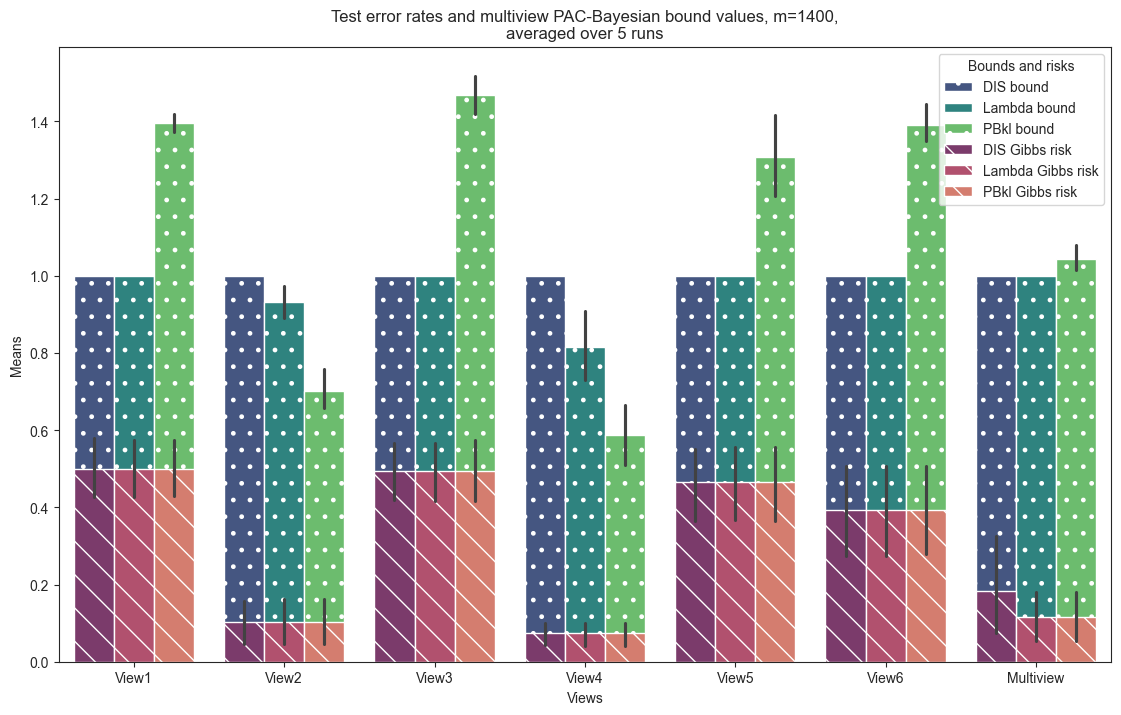

In [9]:
plot_results(df, len(Xs_train[0]))

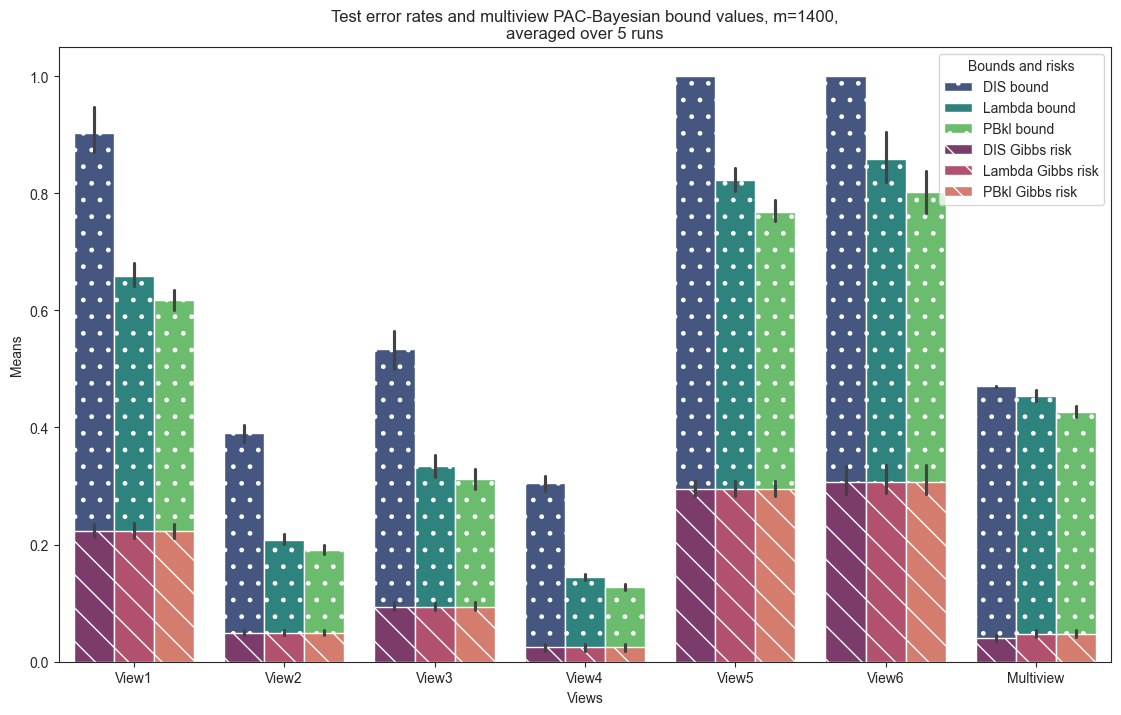

In [9]:
plot_results(df, len(Xs_train[0]))